In [37]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization


from ase.build import bulk
from ase.io.trajectory import Trajectory
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from sklearn.model_selection import train_test_split 
from sklearn.kernel_ridge import KernelRidge 
from dscribe.descriptors import CoulombMatrix, SineMatrix, EwaldSumMatrix, SOAP
from ase import Atoms
from ase.io import read

In [2]:
d = 52

In [5]:
rho0_KIN = np.load('rho_KIN.npy')
rho0_ENE = np.load('rho_ENE.npy')

In [6]:
rho_ks = io.read_density('he.xsf')
rho0_mean = rho_ks.mean()

In [7]:
vW_KE = Functional(type='KEDF',name='vW')
vW_KE(rho_ks).energy

2.498277227554556

In [9]:
def get_ions(path_file):
    inputfile = path_file
    ions = read(inputfile, format='vasp')
    return ions

In [10]:
PP_list = PP_list
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

In [11]:
material = get_ions('he.vasp')

In [13]:
a = material.get_cell()[0]
r = np.sqrt(10**2 + 10**2)
R = np.sqrt(r**2 + 10**2)

In [14]:
WT_KE_ave = Functional(type='KEDF',name='WT')
WT_KE_den = Functional(type='KEDF',name='WT', rho0=1e-6)
WT_KE_kin = Functional(type='KEDF',name='WT', rho0=rho0_KIN)
WT_KE_ene = Functional(type='KEDF',name='WT', rho0=rho0_ENE)
lmgp = Functional(type='KEDF', name='LMGP')
rev_hc = Functional(type='KEDF', name='revHC')
hc = Functional(type='KEDF', name='HC')
vW_KE = Functional(type='KEDF',name='vW')
TF_KE = Functional(type='KEDF',name='TF')
lkt = Functional(type='KEDF',name='lkt')

In [15]:
vw_e = (vW_KE(rho_ks).potential)
wt_kin = (WT_KE_kin(rho_ks).potential)
wt_den = (WT_KE_den(rho_ks).potential)
wt_ene = (WT_KE_ene(rho_ks).potential)
lmgp_pot = lmgp(rho_ks).potential
revHC_pot = rev_hc(rho_ks).potential
hc_pot = hc(rho_ks).potential
lkt_pot = lkt(rho_ks).potential

In [26]:
lkt_pot.

dftpy.field.DirectField

In [16]:
tf_pot = TF_KE(rho_ks).potential

In [17]:
revhc_e =  rev_hc(rho_ks).energy - vW_KE(rho_ks).energy
wt_kin_e =  WT_KE_kin(rho_ks).energy - vW_KE(rho_ks).energy
wt_den_e =  WT_KE_den(rho_ks).energy - vW_KE(rho_ks).energy
wt_ene_e =  WT_KE_ene(rho_ks).energy - vW_KE(rho_ks).energy
lmgp_e   =  lmgp(rho_ks).energy - vW_KE(rho_ks).energy
lkt_e    =  lkt(rho_ks).energy - vW_KE(rho_ks).energy

In [18]:
def rmsd(vw_pot, nl_pot, rho):
    return (np.abs(nl_pot-vw_pot)*rho).integral()/(np.abs(vw_pot)*rho).integral()

In [19]:
revhc_rmsd = rmsd(vw_e, revHC_pot, rho_ks)
wt_kin_rmsd = rmsd(vw_e, wt_kin, rho_ks)
wt_den_rmsd = rmsd(vw_e, wt_den, rho_ks)   
wt_ene_rmsd = rmsd(vw_e, wt_ene, rho_ks)   

lmgp_rmsd  = rmsd(vw_e, lmgp_pot, rho_ks)
lkt_rmsd   = rmsd(vw_e, lkt_pot, rho_ks)

In [20]:
print('rev HC',revhc_e)
print('WT KIN',wt_kin_e)
print('WT DEN', wt_den_e) 
print('WT ENE', wt_ene_e) 
print('LMGP', lmgp_e )  
print('LKT', lkt_e )   

rev HC 1.3464351473434912
WT KIN 1.3700063505872606e-05
WT DEN -0.6495262813468012
WT ENE -0.6380003215029819
LMGP 0.21626366864416102
LKT 1.6357002614118499


In [19]:
print('rev HC', revhc_rmsd)
print('WT KIN',wt_kin_rmsd)
print('WT DEN', wt_den_rmsd) 
print('WT ENE', wt_ene_rmsd) 

print('LMGP', lmgp_rmsd )  
print('LKT', lkt_rmsd ) 

rev HC 0.8164195498035551
WT KIN 0.3485397424083169
WT DEN 0.37803581732222924
WT ENE 0.39639833731010765
LMGP 0.35085118156366263
LKT 1.053054591579053


In [20]:
v_diff =-(vw_e-wt_kin)

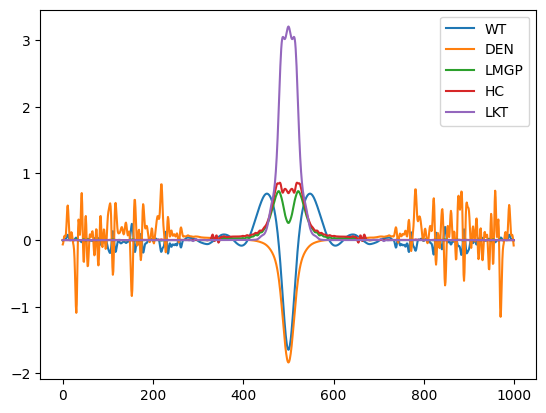

In [23]:
plt.plot(v_diff.get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='WT')
plt.plot(-(vw_e-wt_den).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='DEN')
plt.plot(-(vw_e-lmgp_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='LMGP')
# plt.plot(-(vw_e-revHC_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel())
plt.plot(-(vw_e-hc_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='HC')
plt.plot(-(vw_e-lkt_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='LKT')
plt.legend()

In [23]:
sigma=0.0
den_vw = smooth(vw_e*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_wt = smooth(wt_kin*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_wt_den = smooth(wt_den*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_wt_ene = smooth(wt_ene*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')

den_lkt = smooth(lkt_pot*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_lmgp = smooth(lmgp_pot*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_revhc = smooth(revHC_pot*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')

In [22]:
def smooth(field,sigma=0.3):
    ft = field.fft()
    gg = ft.grid.gg
    ft *= np.exp(-gg*sigma)
    return ft.ifft(force_real=True)

In [127]:
x = den_wt.ravel()

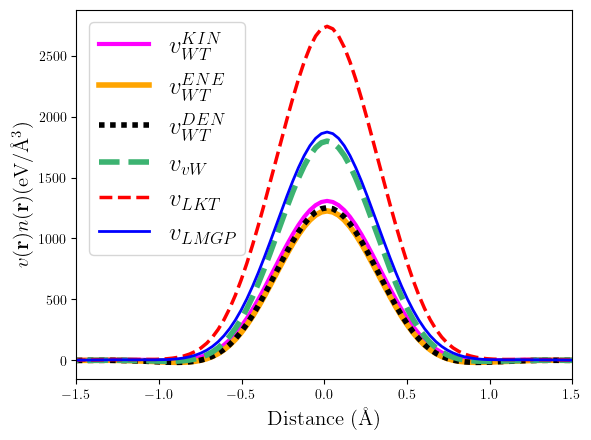

In [36]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
xx= np.linspace(-R,R,len(den_wt.ravel()))
ax = plt.figure().add_subplot(111)
ax.plot(xx, den_wt.ravel()*27.211407/0.529177**3, linewidth=3, color='magenta', label=r'$v_{WT}^{KIN}$')
ax.plot(xx, den_wt_ene.ravel()*27.211407/0.529177**3, linewidth=4.0, color='orange', label=r'$v_{WT}^{ENE}$')
ax.plot(xx, den_wt_den.ravel()*27.211407/0.529177**3, linewidth=4.0, color='black', linestyle=(0, (1,1)), label=r'$v_{WT}^{DEN}$')
ax.plot(xx, den_vw.ravel()*27.211407/0.529177**3, linewidth=4, color='mediumseagreen',linestyle='dashed',label=r'$v_{vW}$')
ax.plot(xx, den_lkt.ravel()*27.211407/0.529177**3, linewidth=2.5, color='red',linestyle='dashed', label=r'$v_{LKT}$')
ax.plot(xx, den_lmgp.ravel()*27.211407/0.529177**3, linewidth=2.0, color='blue', label=r'$v_{LMGP}$')
# plt.plot(den_revhc.ravel(), linewidth=1.5, color='C0', label=r'$v_{revHC}$')

# plt.ylabel('Potential')
plt.legend(fontsize=18)
ax.set_xlim(-1.5,1.5)
# plt.ylim(-0.5,16)
ax.set_xlabel(r'Distance (Å)', fontsize=15)
ax.set_ylabel(r'$v(\textbf{r})  n(\textbf{r}) $(eV/Å$^3$)', fontsize=15)
plt.savefig('pot_WT_vW_1.png', bbox_inches='tight', dpi=200)

In [ ]:
vw_e = (vW_KE(rho_ks).potential)

In [ ]:
wt_kin = (WT_KE_kin(rho_ks).potential)

In [ ]:
plt.plot((vw_e-wt_kin).ravel())
plt.ylim(-10,10)